<a href="https://colab.research.google.com/github/fpgmina/stochastic_simulation/blob/main/WeakConvergenceBrownianMotion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Weak Convergence of a CTMC to Brownian Motion

This notebook demonstrates a fundamental result in stochastic processes: the **weak convergence** of a scaled Continuous-Time Markov Chain (CTMC) to Standard Brownian Motion.

This is a "functional" version of the Central Limit Theorem.
* **Central Limit Theorem:** A scaled *sum* of many random variables converges to a Normal distribution.
* **Donsker's Theorem (which this is):** A scaled *random walk process* converges to a Gaussian process (Brownian Motion).

### The Processes

1.  **Standard Brownian Motion $B(t)$:** This is a continuous-path process.
    * $B(0) = 0$.
    * It has independent increments: $B(t) - B(s)$ is independent of the past.
    * Its increments are normally distributed: $B(t) - B(s) \sim N(0, t-s)$.
    * This implies $\text{Var}[B(t)] = t$.
    * Its paths are continuous, but "jagged" (nowhere differentiable).

2.  **CTMC (Symmetric Random Walk):** This is a jump process.
    * The process waits at a state $x$ for a random time $T \sim \text{Exponential}(\lambda)$.
    * After time $T$, it instantly jumps to a neighbor $x + \Delta x$ or $x - \Delta x$ with 50/50 probability.
    * Its paths are **piecewise-constant**.

### The Goal

We will create a *sequence* of CTMCs, $X_n(t)$, and show that as $n \to \infty$, the *entire path* $X_n(t)$ converges in distribution to the path of $B(t)$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Set a style for the plots
plt.style.use('seaborn-v0_8-whitegrid')

## Section 1: Simulating the Processes

First, we need Python functions to simulate sample paths from both Brownian Motion and our scaled CTMC.

In [2]:
def simulate_BM(T_max, N_steps):
    """
    Simulates a Standard Brownian Motion path B(t) on [0, T_max].

    Args:
        T_max (float): Total time.
        N_steps (int): Number of time steps to discretize.

    Returns:
        tuple: (times, positions) as numpy arrays.
    """
    dt = T_max / N_steps
    # Increments are N(0, dt)
    # We can get this by scaling N(0, 1) by sqrt(dt)
    dz = np.random.normal(0.0, np.sqrt(dt), N_steps)

    # B(t) = sum of increments up to time t
    b_path = np.cumsum(dz)

    # Add the starting point B(0) = 0
    b_path = np.insert(b_path, 0, 0.0)
    times = np.linspace(0.0, T_max, N_steps + 1)

    return times, b_path

In [3]:
def simulate_CTMC(n, T_max):
    """
    Simulates a scaled CTMC path X_n(t) on [0, T_max].

    The scaling is:
    - Jump size: dx = 1 / sqrt(n)
    - Exit rate: lambda = n (n/2 to the left, n/2 to the right)

    Args:
        n (int): The scaling parameter.
        T_max (float): Total time.

    Returns:
        tuple: (times, positions) as lists for step plotting.
    """

    # Define the scaling parameters
    dx = 1.0 / np.sqrt(n)
    lambda_n = float(n) # Total exit rate from any state

    times = [0.0]
    positions = [0.0]

    t_current = 0.0
    x_current = 0.0

    while t_current < T_max:
        # 1. Draw waiting time from Exponential(lambda_n)
        wait_time = np.random.exponential(scale=1.0 / lambda_n)

        t_next = t_current + wait_time

        # If we've gone past the end time, just add the final segment
        if t_next > T_max:
            times.append(T_max)
            positions.append(x_current)
            break

        # 2. Add the point *before* the jump
        times.append(t_next)
        positions.append(x_current)

        # 3. Perform the jump (50/50 chance)
        jump = np.random.choice([-1, 1])
        x_current += (dx * jump)

        # 4. Add the point *after* the jump
        times.append(t_next)
        positions.append(x_current)

        # 5. Update current time
        t_current = t_next

    return times, positions

## Section 2: Visualizing the Convergence of Paths

Now, let's see what happens as we increase $n$.

### The Scaling (The "Magic")

Why this scaling? We need to match the variance.
* The unscaled CTMC (jumps of $\pm 1$, rate $\lambda=n$) is a process $Y_n(t)$. The number of jumps by time $t$, $N(t)$, is roughly $\text{Poisson}(nt)$. The variance of $Y_n(t)$ is $\text{Var}[Y_n(t)] = \lambda t = nt$.
* Our scaled process is $X_n(t) = (\Delta x) \cdot Y_n(t) = \frac{1}{\sqrt{n}} Y_n(t)$.
* The variance of our scaled process is:
    $\text{Var}[X_n(t)] = \text{Var}\left[\frac{1}{\sqrt{n}} Y_n(t)\right] = \frac{1}{n} \text{Var}[Y_n(t)] = \frac{1}{n} (nt) = t$.

This matches the variance of Brownian Motion, $\text{Var}[B(t)] = t$. We are ensuring the "total quadratic variation" matches.

Let's plot the paths for $n = 10$, $n = 100$, $n = 1000$ and compare them to a real Brownian Motion path.

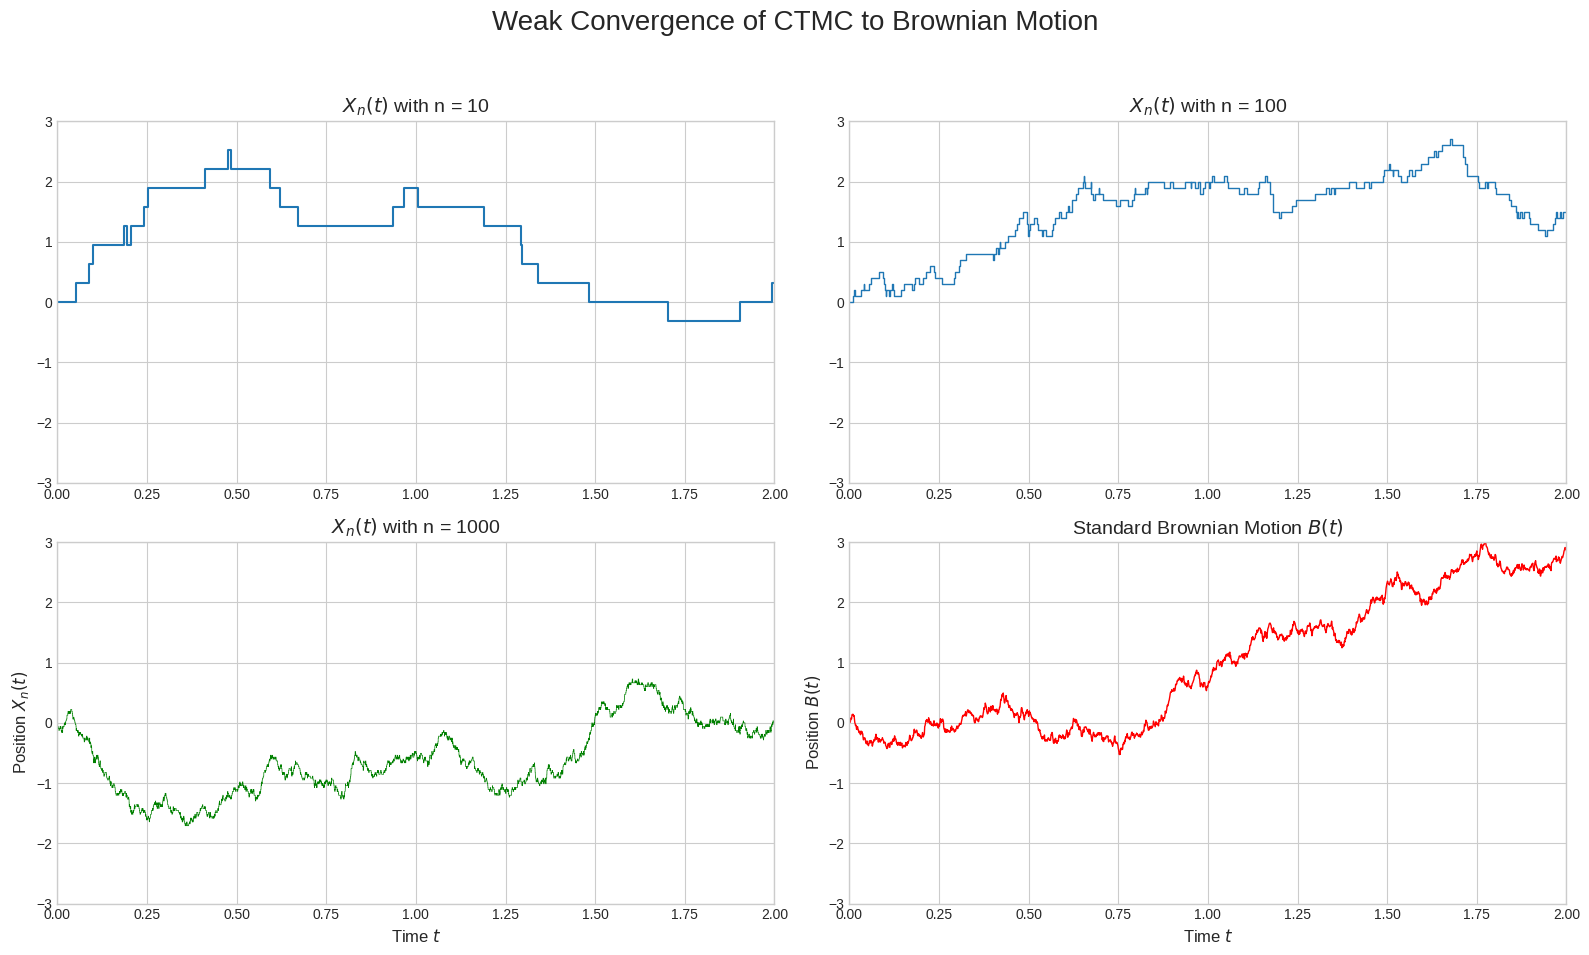

In [4]:
T_MAX = 2.0
np.random.seed(42) # Use a fixed seed for a reproducible comparison

# 1. Simulate one path of Brownian Motion
t_bm, path_bm = simulate_BM(T_MAX, 2000)

# 2. Simulate CTMCs for different n
n_values = [10, 100, 1000]
ctmc_paths = {}
for n in n_values:
    ctmc_paths[n] = simulate_CTMC(n, T_MAX)

# 3. Plot the results
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Weak Convergence of CTMC to Brownian Motion', fontsize=20)

# Plot n=10
ax = axes[0, 0]
t, x = ctmc_paths[10]
ax.plot(t, x, lw=1.5) # Use plot for CTMC; step is built-in
ax.set_title(f'$X_n(t)$ with n = {n_values[0]}', fontsize=14)
ax.set_ylim(-3, 3)
ax.set_xlim(0, T_MAX)

# Plot n=100
ax = axes[0, 1]
t, x = ctmc_paths[100]
ax.plot(t, x, lw=1.0)
ax.set_title(f'$X_n(t)$ with n = {n_values[1]}', fontsize=14)
ax.set_ylim(-3, 3)
ax.set_xlim(0, T_MAX)

# Plot n=1000
ax = axes[1, 0]
t, x = ctmc_paths[1000]
ax.plot(t, x, lw=0.5, color='green')
ax.set_title(f'$X_n(t)$ with n = {n_values[2]}', fontsize=14)
ax.set_ylim(-3, 3)
ax.set_xlim(0, T_MAX)
ax.set_xlabel('Time $t$', fontsize=12)
ax.set_ylabel('Position $X_n(t)$', fontsize=12)

# Plot Brownian Motion
ax = axes[1, 1]
ax.plot(t_bm, path_bm, lw=1.0, color='red')
ax.set_title('Standard Brownian Motion $B(t)$', fontsize=14)
ax.set_ylim(-3, 3)
ax.set_xlim(0, T_MAX)
ax.set_xlabel('Time $t$', fontsize=12)
ax.set_ylabel('Position $B(t)$', fontsize=12)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Analysis of the Plots

* **n = 10:** The path is very clearly a "jump" process. It's piecewise-constant, and you can see the discrete steps.
* **n = 100:** The jumps are much smaller and happen much more frequently. The path starts to look "wiggly" and less like a staircase.
* **n = 1000:** The path is now visually very difficult to distinguish from the true Brownian Motion path. The jumps are so small and fast that they *appear* to form a continuous, jagged line.

This visual evidence is the heart of weak convergence: the *law* (or distribution) of the $X_n$ process is converging to the *law* of the $B$ process in the space of continuous functions.

## Section 3: Convergence of Finite-Dimensional Distributions

"Looking similar" isn't a proof. The formal definition of weak convergence requires two things:
1.  **Convergence of Finite-Dimensional Distributions (f.d.d.s)**
2.  **Tightness** (which we won't prove, but it's what ensures the limit is continuous).

Let's test the f.d.d.s. This means that for any fixed time $t$, the distribution of the random variable $X_n(t)$ must converge to the distribution of $B(t)$.

We know $B(t) \sim N(0, t)$.

Let's test this. We will simulate $M=5000$ paths of $X_n(t)$ for a large $n$ (e.g., $n=100$) and look at their endpoints at $t=1.0$. We then plot a histogram of these 5000 endpoints and see if it matches the target distribution, $N(0, 1)$.

Simulating 10000 paths for n=1000 up to T=1.0...
Simulation complete.


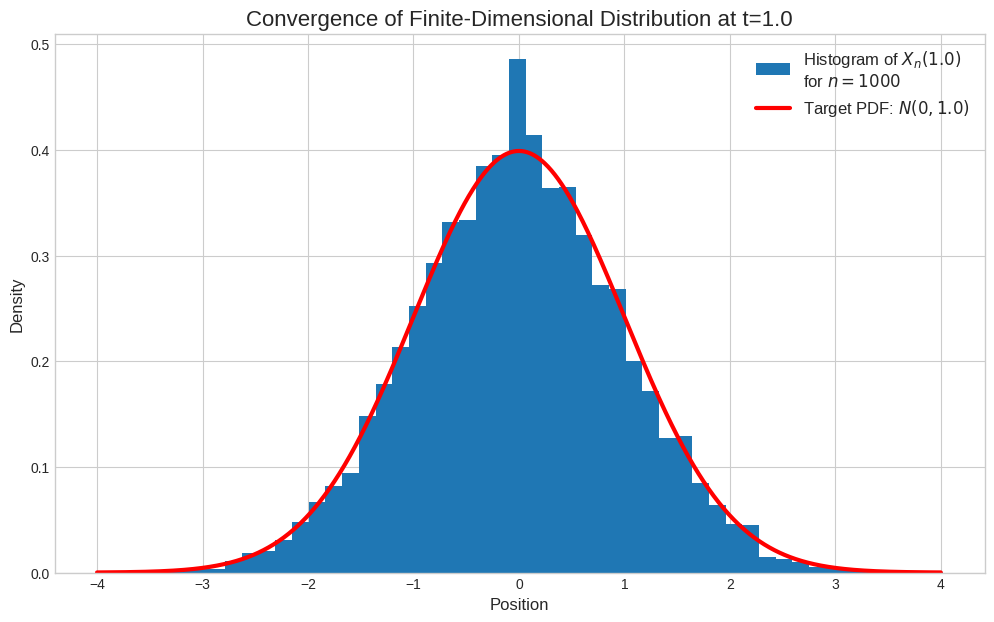

In [5]:
def get_ctmc_endpoint(n, T_final):
    """
    Simulates a *single* scaled CTMC and returns
    only its final position at T_final.
    This is faster than storing the whole path.
    """
    dx = 1.0 / np.sqrt(n)
    lambda_n = float(n)

    t_current = 0.0
    x_current = 0.0

    while True:
        wait_time = np.random.exponential(scale=1.0 / lambda_n)

        if t_current + wait_time > T_final:
            break

        t_current += wait_time
        x_current += (dx * np.random.choice([-1, 1]))

    return x_current

# --- Simulation Parameters ---
N_PATHS = 10000
T_FINAL = 1.0
N_SCALING = 1000 # Our "large n"

print(f"Simulating {N_PATHS} paths for n={N_SCALING} up to T={T_FINAL}...")

# Run the simulation many times
endpoints = [get_ctmc_endpoint(N_SCALING, T_FINAL) for _ in range(N_PATHS)]

print("Simulation complete.")

# --- Plotting ---
plt.figure(figsize=(12, 7))

# 1. Plot the histogram of the endpoints
plt.hist(endpoints, bins=50, density=True, label=f'Histogram of $X_n({T_FINAL})$\nfor $n={N_SCALING}$')

# 2. Plot the target PDF: N(0, T_FINAL)
x_axis = np.linspace(-4, 4, 1000)
target_pdf = stats.norm.pdf(x_axis, 0, np.sqrt(T_FINAL))
plt.plot(x_axis, target_pdf, 'r-', lw=3, label=f'Target PDF: $N(0, {T_FINAL})$')

plt.title(f'Convergence of Finite-Dimensional Distribution at t={T_FINAL}', fontsize=16)
plt.xlabel('Position', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(fontsize=12)
plt.show()

## Conclusion

As the histogram shows, the distribution of the CTMC's position at $t=1.0$ is incredibly well-approximated by the $N(0, 1)$ Gaussian distribution. This demonstrates the **convergence of finite-dimensional distributions**.

This, combined with the **tightness** condition (which intuitively means the paths don't oscillate infinitely wildly), proves that the sequence of scaled CTMC processes $X_n(t)$ converges weakly to Standard Brownian Motion $B(t)$.

This result is powerful because it connects a simple, discrete-jump model (which is often easier to analyze or simulate) to the fundamental, continuous-time process of Brownian Motion that underpins much of modern physics and mathematical finance.